In [ ]:
# default_exp callback.TSBERT

# TSBERT: Self-Supervised Pre-training of Time Series Models

> Callback used to perform the autoregressive task of denoising the input after a binary mask has been applied.

This is an unofficial PyTorch implementation created by Ignacio Oguiza (timeseriesAI@gmail.com) based on:

* Zerveas, G., Jayaraman, S., Patel, D., Bhamidipaty, A., & Eickhoff, C. (2020). [A Transformer-based Framework for Multivariate Time Series Representation Learning. arXiv preprint arXiv:2010.02803v2.](https://arxiv.org/pdf/2010.02803). No official implementation available as far as I know (Oct 10th, 2020)

In [ ]:
#export
from fastai.callback.all import *
from tsai.imports import *
from tsai.utils import *
from tsai.models.utils import *
from tsai.models.layers import *

In [ ]:
#export
from torch.distributions.beta import Beta

In [ ]:
#export
def create_subsequence_mask(o, r=.15, lm=3, stateful=True, sync=False):
    if o.ndim == 2: o = o[None]
    n_masks, mask_dims, mask_len = o.shape
    if sync == 'random': sync = random.random() > .5
    dims = 1 if sync else mask_dims
    numels = n_masks * dims * mask_len
    pm = 1 / lm
    pu = pm * (r / (1 - r))
    a, b, proba_a, proba_b = ([1], [0], pu, pm) if random.random() > pm else ([0], [1], pm, pu)
    if stateful: 
        max_len = max(1, 2 * math.ceil(numels // (1/pm + 1/pu)))
        while True:
            dist_a = np.clip(np.random.geometric(proba_a, max_len), 1, mask_len)
            dist_b = np.clip(np.random.geometric(proba_b, max_len), 1, mask_len)
            if (dist_a + dist_b).sum() >= numels:
                dist_len = np.argmax((dist_a + dist_b).cumsum() >= numels) + 1
                break
        l = [a*ax + b*bx for (ax, bx) in zip(dist_a[:dist_len], dist_b[:dist_len])]
        _mask = list(itertools.chain.from_iterable(l))[:numels]
    else: 
        _mask = np.random.binomial(1, 1 - r, numels)
    mask = torch.Tensor(_mask).reshape(n_masks, dims, mask_len)
    if sync: mask = mask.repeat(1, mask_dims, 1)
    return mask.to(o.device)

def create_variable_mask(o, r=.15):
    n_masks, mask_dims, mask_len = o.shape
    sel_dims = np.random.choice(n_masks * mask_dims, int(n_masks * mask_dims * r), False)
    _mask = np.ones((n_masks * mask_dims, mask_len))
    _mask[sel_dims] = 0
    mask = torch.Tensor(_mask).reshape(*o.shape)
    return mask.to(o.device)

def create_future_mask(o, r=.15):
    n_masks, mask_dims, mask_len = o.shape
    sel_steps = int(round(mask_len * r))
    _mask = np.ones((1, 1, mask_len))
    _mask[..., -sel_steps:] = 0
    mask = torch.Tensor(_mask).repeat(n_masks, mask_dims, 1)
    return mask.to(o.device)

In [ ]:
t = torch.rand(16, 3, 100)
mask = create_subsequence_mask(t, sync=False)
test_eq(mask.shape, t.shape)
mask = create_subsequence_mask(t, sync=True)
test_eq(mask.shape, t.shape)
mask = create_variable_mask(t)
test_eq(mask.shape, t.shape)
mask = create_future_mask(t)
test_eq(mask.shape, t.shape)

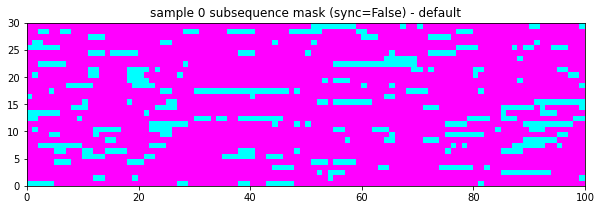

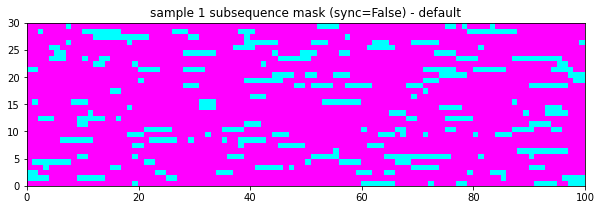

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t)# default settings
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('sample 0 subsequence mask (sync=False) - default')
plt.show()
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[1], cmap='cool')
plt.title('sample 1 subsequence mask (sync=False) - default')
plt.show()

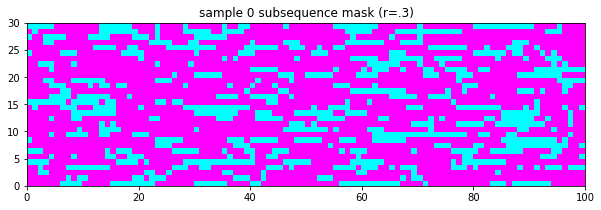

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, r=.3)# 30% of values masked
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('sample 0 subsequence mask (r=.3)')
plt.show()

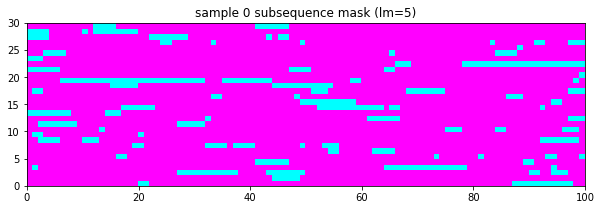

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, lm=5)# average length of mask = 5 
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('sample 0 subsequence mask (lm=5)')
plt.show()

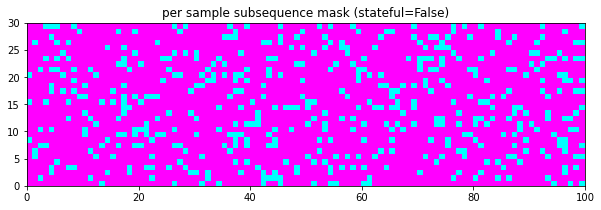

In [ ]:
t = torch.rand(16, 30, 100)
mask = create_subsequence_mask(t, stateful=False)# individual time steps masked 
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('per sample subsequence mask (stateful=False)')
plt.show()

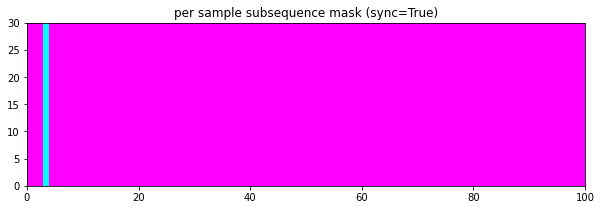

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_subsequence_mask(t, sync=True)# all time steps masked simultaneously
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('per sample subsequence mask (sync=True)')
plt.show()

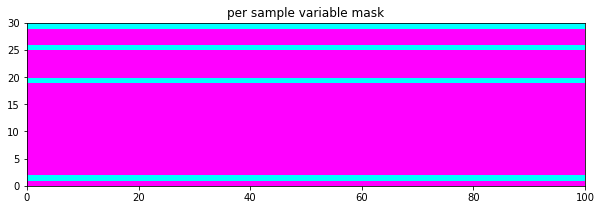

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_variable_mask(t)# masked variables
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('per sample variable mask')
plt.show()

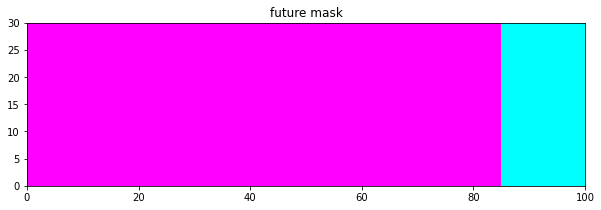

In [ ]:
t = torch.rand(1, 30, 100)
mask = create_future_mask(t)# masked steps
plt.figure(figsize=(10, 3))
plt.pcolormesh(mask[0], cmap='cool')
plt.title('future mask')
plt.show()

In [ ]:
#export
class TSBERT_Loss(Module):
    def __init__(self, crit=None):
        self.crit = ifnone(crit, MSELossFlat())
        self.mask = slice(None)
        
    def forward(self, preds, target):
        return self.crit(preds[self.mask], target[self.mask])

In [ ]:
# export
import matplotlib.colors as mcolors

class TSBERT(Callback):
    def __init__(self, r:float=.15, subsequence_mask:bool=True, lm:float=3., stateful:bool=True, sync:bool=False, variable_mask:bool=False,
                 future_mask:bool=False, custom_mask:Optional=None, dropout:float=.1, crit:callable=None, 
                 target_dir:str='./data/TSBERT', fname:str='model', verbose:bool=True):
        r"""
        Callback used to perform the autoregressive task of denoising the input after a binary mask has been applied.

        Args:
            r: proba of masking.
            subsequence_mask: apply a mask to random subsequences.
            lm: average mask len when using stateful (geometric) masking.
            stateful: geometric distribution is applied so that average mask length is lm.
            sync: all variables have the same masking.
            variable_mask: apply a mask to random variables.
            future_mask: used to train a forecasting model.
            custom_mask: allows to pass any type of mask with input tensor and output tensor.
            dropout: dropout applied to the head of the model during pretraining.
            crit: loss function that will be used. If None MSELossFlat().
            target_dir : directory where trained model will be stored.
            fname : file name that will be used to save the pretrained model.
    """
        assert subsequence_mask or variable_mask or future_mask or custom_mask, \
        'you must set (subsequence_mask and/or variable_mask) or future_mask to True or use a custom_mask'
        if custom_mask is not None and (future_mask or subsequence_mask or variable_mask): warnings.warn("Only custom_mask will be used")
        elif future_mask and (subsequence_mask or variable_mask): warnings.warn("Only future_mask will be used")
        store_attr("subsequence_mask,variable_mask,future_mask,custom_mask,dropout,r,lm,stateful,sync,crit,fname,verbose")
        self.target_dir = Path(target_dir)
        

    def before_fit(self):
        # modify loss for denoising task
        self.old_loss_func = self.learn.loss_func
        self.learn.loss_func = TSBERT_Loss(self.crit)
        self.learn.TSBERT = self
        
        #remove and store metrics
        self.learn.metrics = L([])

        # save initial model head
        assert hasattr(self.learn.model, "head"), f"you can only use {cls_name(self)} with models that have .head attribute"
        backbone = split_model(self.learn.model)[0]
        self.learn.model = backbone

        # prepare model for denoising task
        with torch.no_grad():
            b = self.learn.dls.train.one_batch()
            out = self.learn.model(b[0])
            assert out.ndim == 3, "make sure the backbone (model.head = Noop) produces a 3d output [bs x nf x seq_len]"
            ni = b[0].shape[1]
            if 1 / ni > self.r: self.variable_mask = False
            no = out.shape[1]
            self.learn.model.head = nn.Sequential(nn.Dropout(self.dropout), 
                                                  nn.Conv1d(no, ni, 1)).to(b[0].device) # equivalent to linear layer applied to dim=1
            assert self.learn.model(b[0]).shape == b[0].shape, f"{cls_name(self)} cannot recreate a tensor with the input shape"

    def before_batch(self):
        if self.custom_mask is not None: mask = self.custom_mask(self.x)
        elif self.future_mask: 
            mask = create_future_mask(self.x, r=self.r)
        elif self.subsequence_mask and self.variable_mask:
            random_thr = 1/3 if self.sync == 'random' else 1/2
            if random.random() > random_thr:
                mask = create_subsequence_mask(self.x, r=self.r, lm=self.lm, stateful=self.stateful, sync=self.sync)
            else:
                mask = create_variable_mask(self.x, r=self.r)
        elif self.subsequence_mask:
            mask = create_subsequence_mask(self.x, r=self.r, lm=self.lm, stateful=self.stateful, sync=self.sync)
        elif self.variable_mask:
            mask = create_variable_mask(self.x, r=self.r)
        else: 
            raise ValueError('You need to set subsequence_mask and/ or variable_mask to True in TSBERT.')
            
        self.learn.yb = (self.x,)
        self.learn.xb = (self.x * mask,)
        self.learn.loss_func.mask = (mask == 0) # boolean mask
        self.mask = mask

    def after_fit(self):
        if self.epoch == self.n_epoch - 1 and not "LRFinder" in [cls_name(cb) for cb in self.learn.cbs]:
            PATH = Path(f'{self.target_dir/self.fname}.pth')
            if not os.path.exists(PATH.parent): os.makedirs(PATH.parent)
            torch.save(self.learn.model.state_dict(), PATH)
            pv(f"\npre-trained model weights_path='{PATH}'\n", self.verbose)

    def show_preds(self, max_n=9, nrows=3, ncols=3, figsize=None, sharex=True, **kwargs):
        b = self.learn.dls.valid.one_batch()
        self.learn._split(b)
        xb = self.xb[0].detach().cpu().numpy()
        bs, nvars, seq_len = xb.shape
        self.learn('before_batch')
        pred = learn.model(*self.learn.xb).detach().cpu().numpy()
        mask = self.mask.cpu().numpy()
        masked_pred = np.ma.masked_where(mask, pred)
        ncols = min(ncols, math.ceil(bs / ncols))
        nrows = min(nrows, math.ceil(bs / ncols))
        max_n = min(max_n, bs, nrows*ncols)
        if figsize is None: figsize = (ncols*6, math.ceil(max_n/ncols)*4)
        fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, sharex=sharex, **kwargs)
        idxs = np.random.permutation(np.arange(bs))
        colors = list(mcolors.TABLEAU_COLORS.keys()) + random_shuffle(list(mcolors.CSS4_COLORS.keys()))
        i = 0
        for row in ax:
            for col in row:
                color_iter = iter(colors)
                for j in range(nvars):
                    try: 
                        color = next(color_iter)
                    except: 
                        color_iter = iter(colors)
                        color = next(color_iter)
                    col.plot(xb[idxs[i]][j], alpha=.5, color=color)
                    col.plot(masked_pred[idxs[i]][j], marker='o', markersize=4, color=color)
                i += 1
        plt.tight_layout()
        plt.show()

# Experiments

In [ ]:
from fastai.data.transforms import *
from tsai.data.all import *
from tsai.models.utils import *
from tsai.models.layers import *
from tsai.learner import *
from tsai.models.TSTPlus import *
from tsai.models.InceptionTimePlus import *

In [ ]:
dsid = 'OliveOil'
X, y, splits = get_UCR_data(dsid, split_data=False)
check_data(X, y, splits, False)

X      - shape: [60 samples x 1 features x 570 timesteps]  type: memmap  dtype:float32  isnan: 0
y      - shape: (60,)  type: memmap  dtype:<U1  n_classes: 4 (15 samples per class) ['1', '2', '3', '4']  isnan: False
splits - n_splits: 2 shape: [30, 30]  overlap: [False]


In [ ]:
# Pre-train
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
unlabeled_dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
fname = f'{dsid}_test'
tsbert = TSBERT(subsequence_mask=True, sync='random', variable_mask=True, fname=fname)
learn = ts_learner(unlabeled_dls, InceptionTimePlus, metrics=accuracy, cbs=tsbert) # Metrics will not be used!
learn.fit_one_cycle(1, 3e-3)

epoch,train_loss,valid_loss,time
0,0.901001,0.997048,00:09



pre-trained model weights_path='data/TSBERT/OliveOil_test.pth'



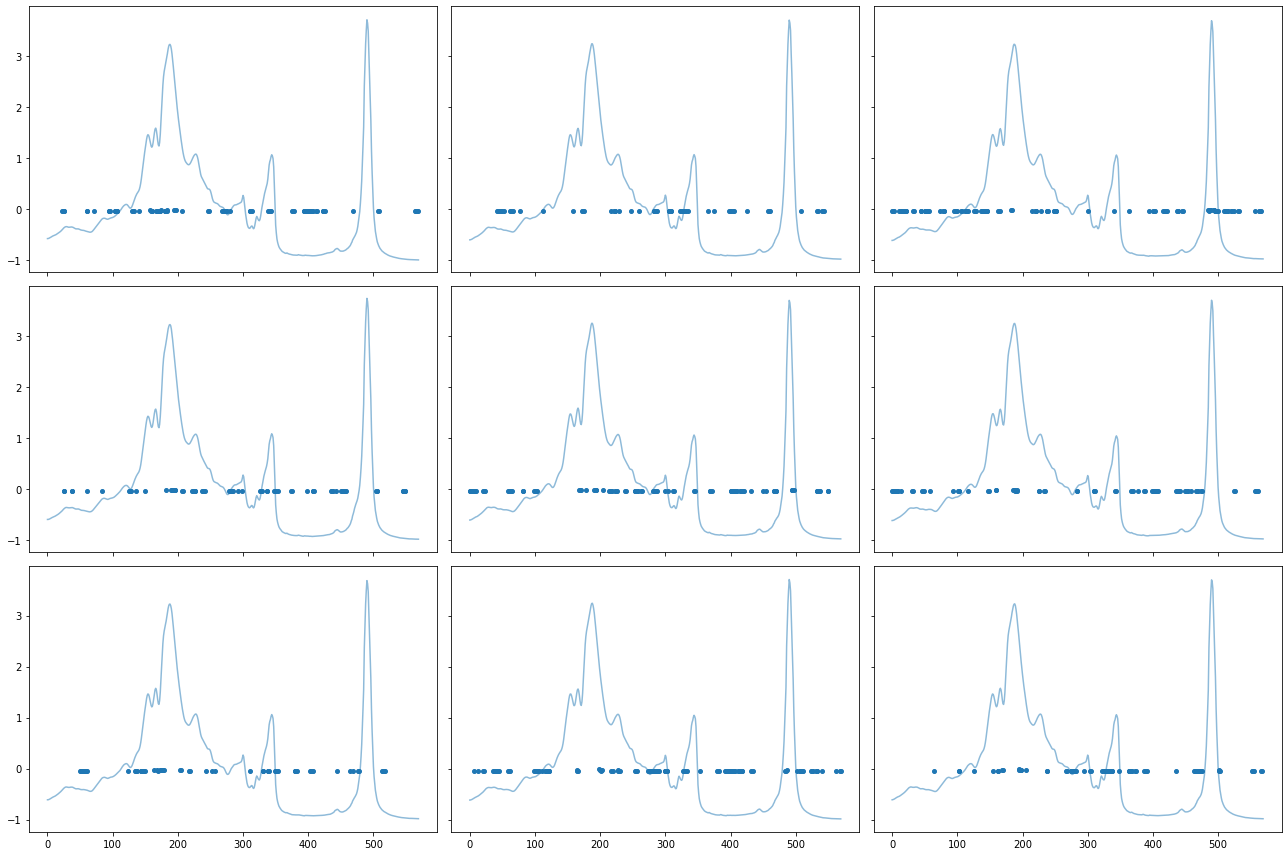

In [ ]:
learn.TSBERT.show_preds(sharey=True) # these preds are highly inaccurate as the model's been trained for just 1 epoch for testing purposes

In [ ]:
# Fine-tune
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
labeled_dls = get_ts_dls(X, y, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
learn = ts_learner(labeled_dls, InceptionTimePlus, pretrained=True, weights_path=f'data/TSBERT/{fname}.pth', metrics=[accuracy])
learn.fine_tune(1)

weights from data/TSBERT/OliveOil_test.pth successfully transferred!



epoch,train_loss,valid_loss,accuracy,time
0,1.321726,1.341909,0.400000,00:09


epoch,train_loss,valid_loss,accuracy,time
0,1.301136,1.340251,0.400000,00:08


In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
unlabeled_dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
fname = f'{dsid}_test'
tsbert = TSBERT(subsequence_mask=True, sync='random', variable_mask=True, future_mask=True, fname=fname)
learn = ts_learner(unlabeled_dls, InceptionTimePlus, metrics=accuracy, cbs=tsbert) # Metrics will not be used!

/Users/nacho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: UserWarning: Only future_mask will be used


In [ ]:
tfms  = [None, [Categorize()]]
batch_tfms = [TSStandardize(by_var=True)]
unlabeled_dls = get_ts_dls(X, splits=splits, tfms=tfms, batch_tfms=batch_tfms, bs=64)
fname = f'{dsid}_test'
tsbert = TSBERT(subsequence_mask=True, sync='random', variable_mask=True, future_mask=True, custom_mask=partial(create_future_mask, r=.15),
                fname=fname)
learn = ts_learner(unlabeled_dls, InceptionTimePlus, metrics=accuracy, cbs=tsbert) # Metrics will not be used!

/Users/nacho/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: Only custom_mask will be used


In [ ]:
# hide
out = create_scripts(); beep(out)